<a href="https://colab.research.google.com/github/HromovAndrey/II_mood_4_part_4/blob/main/%D0%A3%D1%80%D0%BE%D0%BA_%D0%BC%D0%BE%D0%B4%D1%83%D0%BB%D1%8C_4_%D1%87%D0%B0%D1%81%D1%82%D1%8C_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [53]:
import torch
import pandas as pd

device = "cuda" if torch.cuda.is_available() else "cpu"
torch.set_default_device(device)

In [54]:

df = pd.read_csv("https://raw.githubusercontent.com/HalyshAnton/IT-Step-Pyton-AI/main/module3/data/Airline%20Passenger%20Satisfaction.csv",
                 usecols=['Ease of Online booking', 'Inflight wifi service', 'Food and drink', 'Seat comfort', 'satisfaction']
                 )

df['satisfaction'] = df['satisfaction'].map({'satisfied': 1, 'neutral or dissatisfied': 0})

df.head()

,Inflight wifi service,Ease of Online booking,Food and drink,Seat comfort,satisfaction
0,5,3,3,3,1
1,1,3,5,5,1
2,2,2,2,2,0
3,0,0,3,4,1
4,2,4,4,2,1


In [55]:
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split

class MyDataset(Dataset):
  def __init__(self, X, y):
    self.X = torch.FloatTensor(X.values)
    self.y = torch.FloatTensor(y.values)
    self.y = self.y.reshape(-1, 1)

  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):
    return self.X[idx], self.y[idx]

X = df.drop(columns=['satisfaction'])
y = df['satisfaction']
dataset = MyDataset(X, y)

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size=0.8,
                                                    random_state=42,
                                                    stratify=y)
dataset_train = MyDataset(X_train, y_train)
dataset_test = MyDataset(X_test, y_test)

In [57]:
from torch.utils.data import DataLoader

batch_size = 512
train_dl = DataLoader(dataset_test,
                      batch_size=batch_size,
                      shuffle=True)



In [58]:
import numpy as np
from torch import nn
import torch.nn.functional as F

class Block(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()  # Исправлено

        self.linear = nn.Linear(input_dim, output_dim)
        self.linear1 = nn.Linear(output_dim, output_dim)
        self.linear2 = nn.Linear(output_dim, output_dim)

        self.bn1 = nn.BatchNorm1d(output_dim)
        self.bn2 = nn.BatchNorm1d(output_dim)

    def forward(self, x):
        x = self.linear(x)
        x = F.relu(x)

        out = self.linear1(x)
        out = self.bn1(out)
        out = F.relu(out)

        return out + x




In [59]:
class BinaryClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()

        self.all_layers = nn.Sequential(
          Block(input_dim, hidden_dim),
          nn.Dropout(0.2),
          Block(hidden_dim, hidden_dim//2),

          nn.Linear(hidden_dim//2, hidden_dim//2),
          nn.ReLU(),
          nn.Linear(hidden_dim//2, output_dim),
          nn.Sigmoid()
        )

    def forward(self, x):
        return self.all_layers(x)


    def predict(self, X, device='cpu'):
        X = torch.FloatTensor(np.array(X)).to(device)

        with torch.no_grad():
          y_pred = self.forward(X)

        return y_pred.cpu().numpy()


model = BinaryClassifier(4, 128, 1).to(device)
model


BinaryClassifier(
  (all_layers): Sequential(
    (0): Block(
      (linear): Linear(in_features=4, out_features=128, bias=True)
      (linear1): Linear(in_features=128, out_features=128, bias=True)
      (linear2): Linear(in_features=128, out_features=128, bias=True)
      (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Dropout(p=0.2, inplace=False)
    (2): Block(
      (linear): Linear(in_features=128, out_features=64, bias=True)
      (linear1): Linear(in_features=64, out_features=64, bias=True)
      (linear2): Linear(in_features=64, out_features=64, bias=True)
      (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (3): Linear(in_features=64, out_features=64, bias=True)
    (4): ReLU()
    (5): L

In [60]:
from torchsummary import summary

summary(model, input_size=(4,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]             640
            Linear-2                  [-1, 128]          16,512
       BatchNorm1d-3                  [-1, 128]             256
             Block-4                  [-1, 128]               0
           Dropout-5                  [-1, 128]               0
            Linear-6                   [-1, 64]           8,256
            Linear-7                   [-1, 64]           4,160
       BatchNorm1d-8                   [-1, 64]             128
             Block-9                   [-1, 64]               0
           Linear-10                   [-1, 64]           4,160
             ReLU-11                   [-1, 64]               0
           Linear-12                    [-1, 1]              65
          Sigmoid-13                    [-1, 1]               0
Total params: 34,177
Trainable params: 

In [61]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-6)

In [62]:
from torch.optim.lr_scheduler import StepLR
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

In [63]:
import time
def train(model, optimizer, loss_fn, train_dl, val_dl,
          metrics=None, metrics_name=None, epochs=20, device='cpu', task='regression'):
    print('train() called: model=%s, opt=%s(lr=%f), epochs=%d, device=%s\n' % \
        (type(model).__name__, type(optimizer).__name__,
        optimizer.param_groups[0]['lr'], epochs, device))

    # Инициализация метрик, если они не были переданы
    metrics = metrics if metrics else []
    metrics_name = metrics_name if metrics_name else [metric.__name__ for metric in metrics]

    history = {}
    history['lr'] = []
    history['loss'] = []
    history['val_loss'] = []
    for name in metrics_name:
        history[name] = []
        history[f'val_{name}'] = []

    start_time_train = time.time()

    for epoch in range(epochs):

        start_time_epoch = time.time()

        model.train()
        history_train = {name: 0 for name in ['loss']+metrics_name}
        history_val = {name: 0 for name in ['loss']+metrics_name}

        for batch in train_dl:
            x = batch[0].to(device)
            y = batch[1].to(device)
            y_pred = model(x)
            loss = loss_fn(y_pred, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            y_pred = y_pred.detach().cpu().numpy()
            y = y.detach().cpu().numpy()

            history_train['loss'] += loss.item() * x.size(0)
            for name, func in zip(metrics_name, metrics):
                try:
                    history_train[name] += func(y, y_pred) * x.size(0)
                except:
                    if task == 'binary':
                        y_pred_ = y_pred.round()
                    elif task == 'multiclass':
                        y_pred_ = y_pred.argmax(axis=-1)

        for name in history_train:
            history_train[name] /= len(train_dl.dataset)

        end_time_epoch = time.time()

        for name in history_train:
            history[name].append(history_train[name])
            history['val_'+name].append(history_val.get('val_'+name, 0))

        total_time_epoch = end_time_epoch - start_time_epoch

        print(f'Epoch {epoch+1:4d} {total_time_epoch:4.0f}sec_', end='\t')
        for name in history_train:
            print(f'{name}: {history[name][-1]:10.3g}', end='\t')
        print()

    end_time_train = time.time()
    total_time_train = end_time_train - start_time_train
    print()
    print('Time total: %5.2f sec' % (total_time_train))
    return history


In [65]:
test_dl = DataLoader(dataset_test,
                     batch_size=batch_size,
                     shuffle=False)

In [66]:
from sklearn.metrics import accuracy_score, roc_auc_score

history = train(model, optimizer, loss_fn, train_dl, test_dl,
                epochs=20,
                metrics=[accuracy_score, roc_auc_score],
                device=device,
                task='binary')

train() called: model=BinaryClassifier, opt=Adam(lr=0.010000), epochs=20, device=cpu

Epoch    1    0sec_	loss:      0.569	accuracy_score:          0	roc_auc_score:      0.771	
Epoch    2    0sec_	loss:      0.483	accuracy_score:          0	roc_auc_score:      0.841	
Epoch    3    0sec_	loss:      0.468	accuracy_score:          0	roc_auc_score:      0.845	
Epoch    4    0sec_	loss:      0.457	accuracy_score:          0	roc_auc_score:      0.854	
Epoch    5    0sec_	loss:      0.455	accuracy_score:          0	roc_auc_score:      0.852	
Epoch    6    0sec_	loss:      0.457	accuracy_score:          0	roc_auc_score:      0.853	
Epoch    7    0sec_	loss:      0.449	accuracy_score:          0	roc_auc_score:      0.857	
Epoch    8    0sec_	loss:      0.451	accuracy_score:          0	roc_auc_score:      0.859	
Epoch    9    0sec_	loss:      0.452	accuracy_score:          0	roc_auc_score:       0.86	
Epoch   10    0sec_	loss:      0.446	accuracy_score:          0	roc_auc_score:       0.86	
Epoc

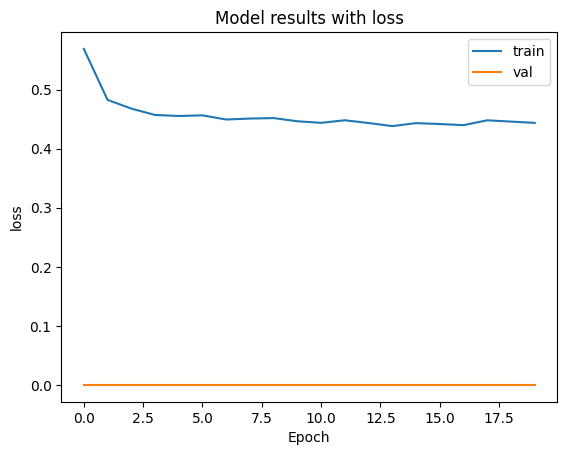

In [69]:
import matplotlib.pyplot as plt

def plot_metric(history, name):
    plt.title(f"Model results with {name}")
    plt.plot(history[name], label='train')
    plt.plot(history['val_'+name], label='val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    plt.legend()
    plt.show()

plot_metric(history, 'loss')


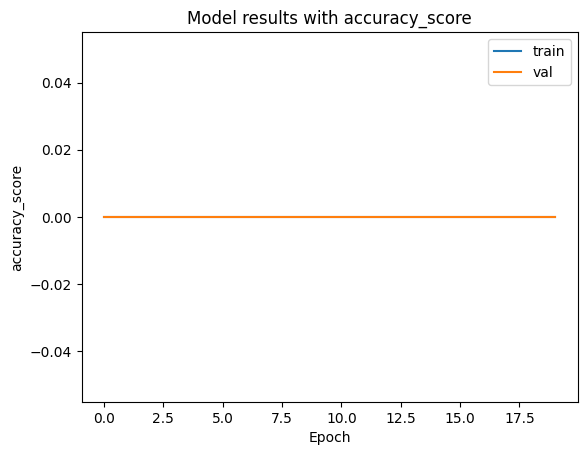

In [70]:
plot_metric(history, 'accuracy_score')

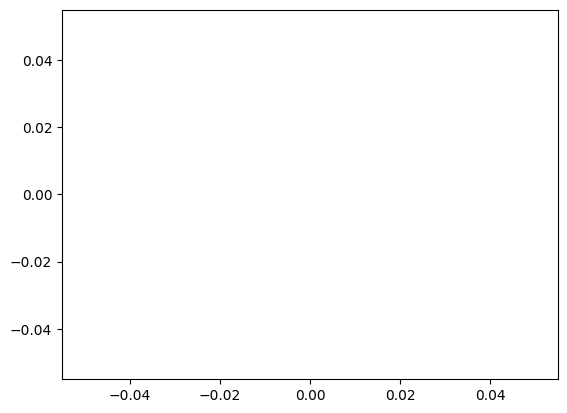

In [71]:
plt.plot(history['lr'])

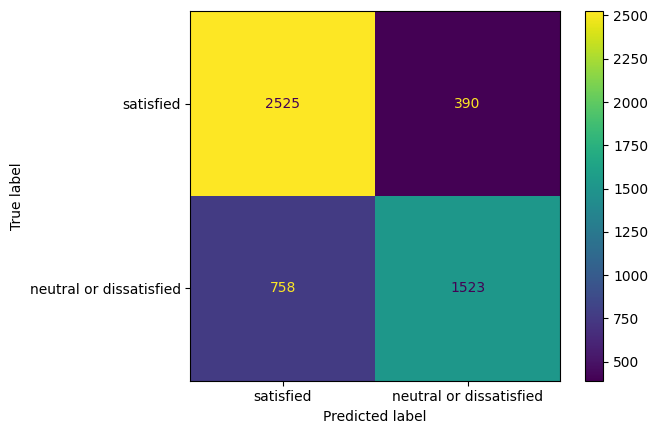

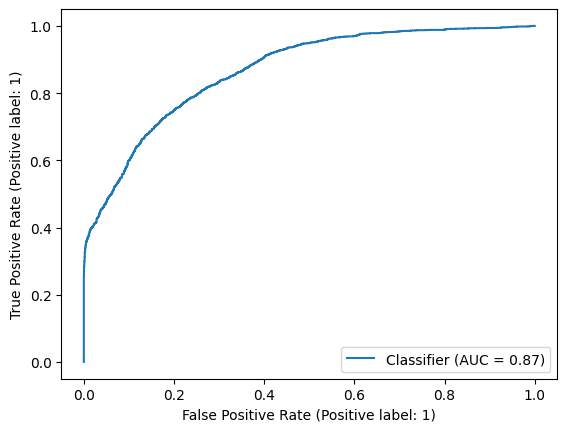

In [72]:
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay

model = model.to('cpu')
y_pred = model.predict(X_test)

ConfusionMatrixDisplay.from_predictions(y_test, y_pred.round(),
                                        display_labels=['satisfied', 'neutral or dissatisfied'])
plt.plot()

RocCurveDisplay.from_predictions(y_test, y_pred, pos_label=1)
